# Classify BBB molecules using ChemBERTa

- Load BBB dataset with pre-defined train-test split 
- Load pretrained model from HuggingFace
- Fine-tune pretrained model using BBB dataset
- Evaluate the models performance

In [1]:
!pip install transformers
!pip install simpletransformers

Mount google drive to access files

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
from simpletransformers.classification import ClassificationModel
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import sklearn

2023-06-02 11:59:08.529603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 11:59:09.389742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
train_df = pd.read_csv("https://staicentreprod001.blob.core.windows.net/share/mlprague23/B3DB_cleaned_SMILES_TRAIN.csv")
train_df = train_df.drop(columns=["split"]) # again, you might not need this line
train_df.head()

SMILES  label
0                    C/C=C/C(=O)N(CC)C(CC)C(=O)N(C)C      1
1  CN1CCN(CCN2CCN(CCCN3c4ccccc4Sc4ccc(Cl)cc43)CC2...      1
2                                     CC(=O)OCCC(C)C      1
3             Cc1nnc2n1-c1sc(Br)cc1C(c1ccccc1Cl)=NC2      1
4              COc1ccc2c(c1)/C(=C/CCN(C)C)c1ccccc1O2      1

In [5]:
test_df = pd.read_csv("https://staicentreprod001.blob.core.windows.net/share/mlprague23/B3DB_cleaned_SMILES_TEST.csv")
test_df = test_df.drop(columns=["split"])
test_df.head()

SMILES  label
0  CCCCc1oc2ccc(NS(C)(=O)=O)cc2c1C(=O)c1ccc(OCCCN...      0
1  CCOC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)C(CN2CCCC...      1
2  CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(...      1
3                          COc1ccc(Cl)c2c1CCCC2N(C)C      1
4            Cc1cc(-c2cc(N)n3nc(-c4ccccn4)nc3c2)ccn1      1

In [7]:
model = ClassificationModel('roberta', model_name, args={'num_train_epochs': 2, 'overwrite_output_dir': True}, use_cuda=False)

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and a

In [8]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir ChemBERTa_test_run

In [ ]:
# Train the model
model.train_model(train_df, eval_df=test_df, output_dir='/content/ChemBERTa_test_run')

/home/joe/anaconda3/envs/mlprague2023-nlp/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3364 [00:00<?, ?it/s]

In [ ]:
# evaluation 
# documentation: https://simpletransformers.ai/docs/classification-models/#evaluating-a-classification-model
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.f1_score)
pred_test = np.argmax(model_outputs, axis=-1)

# print results
print(result)
print(model_outputs)
print(wrong_predictions)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/842 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

{'mcc': 0.6175519093707921, 'tp': 491, 'tn': 208, 'fp': 78, 'fn': 65, 'auroc': 0.8921649393771695, 'auprc': 0.9386015993063205, 'acc': 0.8728888888888889, 'eval_loss': 0.46136797317918743}
[[-0.38867188 -0.03173828]
 [-2.86132812  2.18554688]
 [ 0.87304688 -0.30761719]
 ...
 [ 1.36914062 -0.82275391]
 [ 1.1328125  -0.97558594]
 [ 2.2421875  -1.69726562]]
[{'guid': 0, 'text_a': 'CCCCc1oc2ccc(NS(C)(=O)=O)cc2c1C(=O)c1ccc(OCCCN(CCCC)CCCC)cc1', 'text_b': None, 'label': 0}, {'guid': 2, 'text_a': 'CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(=O)c1ccc(N)cc1', 'text_b': None, 'label': 1}, {'guid': 18, 'text_a': 'CS(=O)(=O)[C@@H]1[C@H](c2ccc3c(c2)OCO3)[C@@]1(N)CO', 'text_b': None, 'label': 0}, {'guid': 20, 'text_a': 'CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1', 'text_b': None, 'label': 1}, {'guid': 36, 'text_a': 'OC1OC(COCCOC(O)C(Cl)(Cl)Cl)C(OC2OC(COCCOCCOC(O)C(Cl)(Cl)Cl)CC(OC(O)C(Cl)(Cl)Cl)C2O)C(OCCOCCOC(O)C(Cl)(Cl)Cl)C1O', 'text_b': None, 'label': 1}, {'guid': 42, 'text_a': 'CCC(NC(=O)c1

In [ ]:
example_predictions, example_raw_outputs = model.predict(['COc1ccc(Cl)c2c1CCCC2N(C)C'])
print(example_predictions)
print(example_raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[1]
[[-2.31445312  1.51855469]]


In [ ]:
print("Test accuracy: {:.2f}".format(sklearn.metrics.accuracy_score(test_df.label, pred_test)))

print(sklearn.metrics.classification_report(test_df.label, pred_test, digits=2))

Test accuracy: 0.83
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       286
           1       0.86      0.88      0.87       556

    accuracy                           0.83       842
   macro avg       0.81      0.81      0.81       842
weighted avg       0.83      0.83      0.83       842



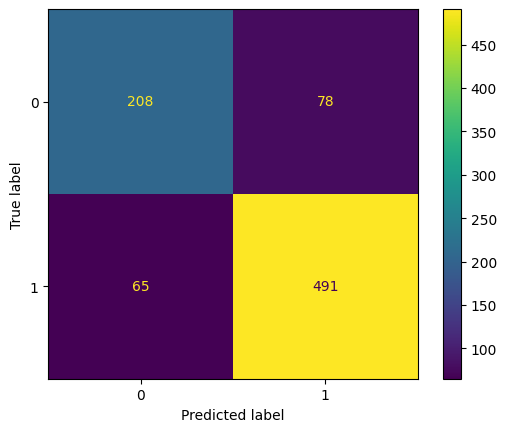

In [ ]:
print(sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_df.label, pred_test))